In [1]:
import sys
sys.path.insert(0, '/home/yw440/MXGPY/mxgpy')
sys.path.insert(0, '/home/yw440/MyRGPs/')
import os
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'

import scipy.io
from pylab import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import GPy
import numpy as np
np.random.seed(101)

from mxgpy.rgp.rgp import RGP 
from mxgpy.kernel.rbf import RBF
import mxnet as mx
ctx = mx.gpu()
mx.Context.default_ctx = ctx

from mxgpy.util import positive_transform_reverse_numpy
import helper

 /anaconda/envs/py35/lib/python3.5/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning:OpenSSL.rand is deprecated - you should use os.urandom instead
 /anaconda/envs/py35/lib/python3.5/site-packages/mxnet/context.py:144: DeprecationWarning:Context.default_ctx has been deprecated. Please use Context.current_context() instead. Please use test_utils.set_default_context to set a default context


In [2]:
Fs, f, sample = 200, 4, 500
x = np.arange(sample)
yx = np.sin(2*np.pi*f*x/Fs).reshape(sample,1)

yw_test = yx

# Mapping in both latent and observation layer

In [3]:
## -- Training -- ##
YD = 1 #np.shape(yx)[1] # dimension of the data, 62 dimension
HD = 1
win_out = 20 # only consider the feature from previous time step

m = RGP(wins=[win_out, win_out], with_control=False, X_dims=[HD, YD], num_inducing=50,
            kernels=[RBF(win_out*HD, ARD=True, name='rbf0'), RBF(win_out*HD+win_out*YD, ARD=True, name='rbf1')],
            nSamples=5, q_hidden_units=[100], h0_hidden_units=[100], ctx=ctx, dtype=np.float64)

## Initialize parameters
m.collect_params()['rbf0_variance'].set_data(positive_transform_reverse_numpy(np.array([1.]), np.float64))
m.collect_params()['rbf0_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*HD,))*5,np.float64))
m.collect_params()['rbf1_variance'].set_data(positive_transform_reverse_numpy(np.array([1.]), np.float64))
m.collect_params()['rbf1_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*YD+win_out*HD,))*3,np.float64))
m.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([0.0001]),np.float64))
m.collect_params()['layer_1_noise_var'].set_data(positive_transform_reverse_numpy(np.array([0.0001]),np.float64))
    
m.optimize(Y=[yx[win_out:]], max_iters=500, step_rate=0.03)
m.optimize(Y=[yx[win_out:]], max_iters=500, step_rate=0.01)

100%|██████████| 500/500 [19:39<00:00,  2.36s/it, loss=-335]   


In [6]:
m.optimize(Y=[yx[win_out:]], max_iters=500, step_rate=0.01)

100%|██████████| 500/500 [19:37<00:00,  2.35s/it, loss=-2.07e+03]


In [7]:
## --- testing --- ##
y_sin = m.freerun(yx.shape[0]-win_out, init_X=yx[:win_out], mean_predict=False, nSamples=100)

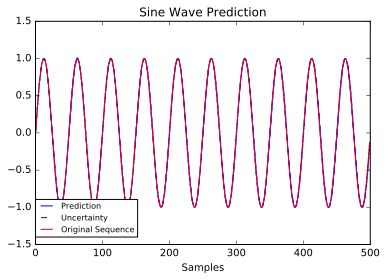

In [8]:
pred, = plot(y_sin[:,:,0].mean(0),'b')
lower, = plot(y_sin[:,:,0].mean(0)-y_sin[:,:,0].std(0)*2, 'b--')
upper, = plot(y_sin[:,:,0].mean(0)+y_sin[:,:,0].std(0)*2, 'b--')
orig, = plot(yx[:,0],'r',label='ground-truth')
xlabel("Samples")
title("Sine Wave Prediction")
# legend([pred,lower,orig],["Prediction", "Uncertainty", "Original Sequence"], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend([pred,lower,orig],["Prediction", "Uncertainty", "Original Sequence"], bbox_to_anchor=(0., .1, 1., .102), loc=2,
          fontsize=8, ncol=1, borderaxespad=0.)
savefig("sine_wave.png")

In [9]:
y_sin = m.freerun(1000, init_X=yx[:win_out], mean_predict=False, nSamples=100)

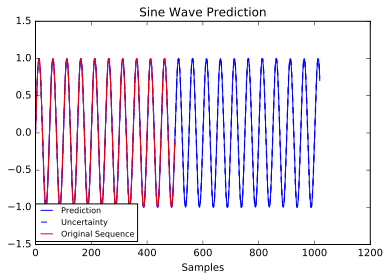

In [10]:
plot(y_sin[:,:,0].mean(0),'b')
plot(y_sin[:,:,0].mean(0)-y_sin[:,:,0].std(0)*2, 'b--')
plot(y_sin[:,:,0].mean(0)+y_sin[:,:,0].std(0)*2, 'b--')
plot(yx[:,0],'r',label='ground-truth')
xlabel("Samples")
title("Sine Wave Prediction")
legend([pred,lower,orig],["Prediction", "Uncertainty", "Original Sequence"], bbox_to_anchor=(0., .08, 1., .102), loc=2,
          fontsize=8, ncol=1, borderaxespad=0.)
plt.savefig("sine_wave(long).png")

In [16]:
m.show_params(RBF_param=False)

{'layer_0': {'inducing_inputs': array([[ 2.78287104e+00,  1.08357031e+00,  1.52517254e+00,
           9.11540009e-01,  8.53455992e-01,  1.73357879e-01,
          -9.23670006e-01,  1.71487353e+00, -2.08639853e+00,
           6.96251424e-01,  1.02136843e+00, -4.34816178e-01,
           8.62145459e-01, -3.73956808e-01, -9.81359233e-01,
           1.29304275e+00, -3.41631956e-01,  2.27780343e+00,
           2.09709620e+00,  6.41253257e-01],
         [-1.12357236e-01,  1.48428308e+00, -6.88971959e-01,
          -1.25162284e+00,  1.03171531e-01,  5.59935457e-01,
           4.74306660e-01, -4.66776289e-02,  5.52257576e-01,
           3.59669894e-01,  1.11684103e+00,  6.39428359e-01,
          -5.67287075e-02, -3.91455745e-02, -7.05394220e-01,
           2.77484771e-01, -7.50470820e-01,  1.22953081e+00,
           3.43148661e-02,  7.44624758e-01],
         [-1.05580875e+00, -5.58671345e-01, -3.27941344e+00,
           6.62358775e-01,  1.44560891e+00, -5.31763322e-01,
          -3.01659965e-01,

# No mapping in observation layer

In [17]:
## -- Training -- ##
YD = 1 #np.shape(yx)[1] # dimension of the data, 62 dimension
HD = 1
win_latent = 10 # only consider the feature from previous time step
win_out = 20
m1 = RGP(wins=[win_latent, win_out], with_control=False, X_dims=[HD, YD], num_inducing=50,
            kernels=[RBF(win_latent*HD, ARD=True, name='rbf0'), RBF(win_latent*HD+win_out*YD, ARD=True, name='rbf1')],
            nSamples=5, q_hidden_units=[100], h0_hidden_units=[100], ctx=ctx, dtype=np.float64)

## Initialize parameters
m1.collect_params()['rbf0_variance'].set_data(positive_transform_reverse_numpy(np.array([1.]), np.float64))
m1.collect_params()['rbf0_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_latent*HD,)),np.float64))
m1.collect_params()['rbf1_variance'].set_data(positive_transform_reverse_numpy(np.array([1.]), np.float64))
m1.collect_params()['rbf1_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_latent*HD+win_out*YD,))*3,np.float64))
m1.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([0.001]),np.float64))
m1.collect_params()['layer_1_noise_var'].set_data(positive_transform_reverse_numpy(np.array([0.001]),np.float64))
    
m1.optimize(Y=[yx[win_out:]], max_iters=500, step_rate=0.03)
m1.optimize(Y=[yx[win_out:]], max_iters=500, step_rate=0.01)

  0%|          | 0/500 [00:00<?, ?it/s]


MXNetError: Shape inconsistent, Provided = [100,20], inferred shape=(100,10)